### 🔧 Notebook Setup — Auto-Reload & Project Path

Before we start exploring different agent types and execution modes, we need to set up
our Jupyter environment so that it can import the Neurosurfer project cleanly and 
pick up code changes automatically.

### 📌 What this cell does

1. **Enables autoreload**  
   This makes Jupyter reload modules automatically whenever you modify the source code.  
   No need to restart the kernel each time you edit a Python file.

2. **Adds your project root to `sys.path`**  
   Your notebook likely lives inside a subfolder such as `b/` or `notebooks/`.  
   By moving one directory up and appending it to `sys.path`, Python can import your
   local Neurosurfer modules as if they were installed packages.


In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

# Go up one directory from `b/` to project root
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

## 🤖 Initializing the Local LLM (Qwen3-8B-Unsloth)

This cell prepares the language model that all agents in this notebook will use.  
We load a locally stored Qwen3-8B model, quantized in 4-bit mode for efficient GPU usage.

### 🔧 What happens in this step
- **GPU memory is cleared** to avoid leftover allocations from earlier runs.
- **Model configuration parameters** are defined (model path, max sequence length, quantization mode, stop words, verbosity).
- **The TransformersModel wrapper is created**, which handles:
  - GPU/CPU device selection  
  - automatic dtype (bfloat16 on CUDA)
  - thread-safe generation
  - streaming support and stop-token detection
  - integration with all Neurosurfer agents

### 📌 Why this matters
All subsequent components — ReActAgent, CodeAgent, RAG workflows, and the Main Workflow —
reuse this single `LLM` instance.  
It ensures consistent generation behavior, reduced memory footprint, and faster warm-up.

### ⚙️ Key configuration highlights
- **model_name**: filesystem path to your local 4-bit Qwen3-8B model  
- **max_seq_length**: extended context window for longer agent chains  
- **load_in_4bit=True**: enables efficient inference on mid-range GPUs  
- **enable_thinking=False**: disables structured “thinking mode” tokens  
- **stop_words**: early-stop hints for streaming (e.g., “Observation:”)

After running this cell, the model is ready for use by all agents in the tutorial.


In [2]:
import logging
from neurosurfer.models.chat_models.transformers import TransformersModel
from neurosurfer.models.chat_models.openai import OpenAIModel
from neurosurfer import config 
import torch
torch.cuda.empty_cache()

LOGGER = logging.getLogger()

DEFAULT_TRANSFORMERS_MODEL_PARAMS = dict({
    "model_name": "/home/nomi/workspace/Model_Weights/Qwen3-8B-unsloth-bnb-4bit",
    "max_seq_length": 12000,
    "load_in_4bit": True,
    "enable_thinking": False,  # main_gpu interpretation
    "verbose": False
})

LLM = TransformersModel(
    **DEFAULT_TRANSFORMERS_MODEL_PARAMS,
    stop_words=["Observation:"],
    logger = logging.getLogger(),
)

# LLM = OpenAIModel(
#     model_name="qwen3-8b",
#     base_url="http://localhost:9999/v1",
#     api_key="abc",
#     strip_reasoning=True,
#     stop_words=[],
#     logger=LOGGER,
# )

╔══════════════════════════════════════════════════════════════════╗
║                                                                  ║
║ ▓▓▓▓▓   ▓▓▓▓                                  ▓▓▓                ║
║  ▓▓ ▓▓   ▓▓  ▓▓▓▓ ▓  ▓ ▓ ▓ ▓▓▓▓ ▓▓▓ ▓  ▓ ▓ ▓  ▓   ▓▓▓▓ ▓ ▓       ║
║  ▓▓  ▓▓  ▓▓  ▓▁▁▓ ▓  ▓ ▓▓▏ ▓  ▓ ▓▁  ▓  ▓ ▓▓▏ ▓▓▓  ▓▁▁▓ ▓▓        ║
║  ▓▓   ▓▓ ▓▓  ▓    ▓  ▓ ▓   ▓  ▓   ▓ ▓  ▓ ▓    ▓   ▓    ▓         ║
║ ▓▓▓▓   ▓▓▓▓▓ ▓▓▓▓ ▓▓▓▓ ▓   ▓▓▓▓ ▓▓▓ ▓▓▓▓ ▓    ▓   ▓▓▓▓ ▓         ║
║ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ║
║ Orchestrate Agents - RAG - SQL Tools - Multi-LLM - FastAPI Ready ║
║ Faster builds, clearer flows, production-first                   ║
║                                                                  ║
║ Version: 0.1.0 | Python: 3.12.12                                 ║
║ OS: Linux 6.17.0-8-generic (x86_64)                              ║
║ Torch: 2.9.0+cu130   CUDA: yes (13.0)                            ║
║ MPS: no (built: False)          

/home/nomi/micromamba/envs/LLMs/lib/python3.12/importlib/__init__.py:90: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  return _bootstrap._gcd_import(name[level:], package, level)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
#### Unsloth: `hf_xet==1.1.10` and `ipykernel>6.30.1` breaks progress bars. Disabling for now in XET.
#### Unsloth: To re-enable progress bars, please downgrade to `ipykernel==6.30.1` or wait for a fix to
https://github.com/huggingface/xet-core/issues/526
WARNING  | 2026-01-04 11:10:18 | _cpp_lib.py:<module> | WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.9.0+cu130)
    Python  3.9.23 (you have 3.12.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers does not work in RTX 50X, Blackwell GPUs as of yet. Please build from source via
```
pip install ninja
pip install -v --no-build-i

/home/nomi/workspace/neurosurfer/neurosurfer/__init__.py:46: UserWarning: Some optional LLM dependencies are not installed: unsloth.
      Neurosurfer core will load, but LLM features (model loading, HF/Unsloth, BnB quant, etc.)
      will be unavailable until you install them.

      To install everything with one extra:
        - pip install 'neurosurfer[torch]'

      Or use one of these commands:

- pip install -U 'neurosurfer[torch]'
- pip install -U accelerate sentence-transformers transformers unsloth
- pip install -U torch --index-url https://download.pytorch.org/whl/cpu
- pip install -U torch --index-url https://download.pytorch.org/whl/cu124
  warn_optional_llm_stack()
`torch_dtype` is deprecated! Use `dtype` instead!


INFO     | 2026-01-04 11:10:19 | modeling.py:get_balanced_memory | We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO     | 2026-01-04 11:10:23 | transformers.py:init_model | Transformers model initialized successfully.


##### 📝 Streaming a Simple LLM Response

This cell demonstrates how to stream tokens directly from the model in real time.  
We send a system prompt and user message, enable `stream=True`, and print each token as it arrives.  
Streaming is useful for interactive agent outputs, debugging, and understanding how the model generates text step by step.


In [4]:
# streaming response example
from IPython.display import display, Markdown, clear_output

system_prompt = "/nothink You are a joker."
user_prompt = """Tell me a short and light-hearted joke."""

stream_response = LLM.ask(
    system_prompt=system_prompt,
    user_prompt=user_prompt,
    stream=True
)

md_display = display(Markdown(""), display_id=True)
for chunk in stream_response:
    chunk = chunk.choices[0].delta.content or ""
    print(chunk, flush=True, end="")

Why don't skeletons fight each other?  
Because they don't have the *guts*! 😄

## 🤖 Using the Generic Agent (LLM-Only Mode)

This section introduces the basic `Agent` class, which provides a lightweight wrapper around an LLM without invoking tools or complex workflows. It supports both normal (non-streaming) responses and streaming output.

### 🔧 What this cell demonstrates
- Creating an `Agent` with a simple configuration (temperature, token limit, streaming defaults).
- Sending a plain natural-language query and receiving a direct response.
- Showing how the agent integrates tracing, routing logic, and output handling behind the scenes.

### 📌 When to use this agent
Use the generic `Agent` whenever you want:
- a straightforward LLM response,
- optional structured JSON outputs,
- optional tool routing if a Toolkit is attached,
- lightweight experimentation without the full MainWorkflow.

This provides the foundation before moving on to more advanced agents like ReAct, CodeAgent, or RAGAgent.


In [5]:
# agent normal response
from neurosurfer.agents import Agent, AgentConfig
# from neurosurfer.tracing import RichTracer
from pydantic import BaseModel

agent_config = AgentConfig(
    strict_tool_call=True,
    return_stream_by_default=True,
    temperature=0.7,
    max_new_tokens=4096,
)
agent = Agent(llm=LLM, config=agent_config, log_traces=True)

# normal response
agent_response = agent.run(user_prompt="What is AI (one line)?", stream=False)
print("\nNormal Response:")
print(agent_response.response)

# # streaming response
# print("\n\nStreaming Response:")
# for c in agent.run(user_prompt="What are top 3 applications of AI (one line)?").response:
#     print(c, flush=True, end="")



[main_agent] 🧠 Thinking...
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
    [main_agent] Starting llm.call...
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.free_text_call'
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.free_text_call' took 0.708s; error=False
    [main_agent] Completed llm.call!
 ◀ [1][step.agent] agent_id='main_agent' label='agent.run' took 0.711s; error=False
[main_agent] 🧠 Done!

Normal Response:
AI, or Artificial Intelligence, is the simulation of human intelligence in machines that are programmed to think, learn, and perform tasks typically requiring human cognition.


### 📦 Structured Responses with Pydantic Models

This example shows how the Agent can produce **validated, structured outputs** instead of free-form text. By providing a Pydantic schema, the Agent is prompted to return JSON that matches the required fields, and any malformed output is automatically repaired or retried.

### 🔧 What this cell demonstrates
- Defining custom Pydantic models to shape the LLM’s output.
- Asking the Agent a natural-language query while enforcing a specific schema.
- Receiving a clean `json_obj` back, already parsed and validated.

### 📌 Why structured responses matter
Structured outputs make downstream processing far easier — especially for:
- pipelines,
- UI rendering,
- database inserts,
- chaining multiple agents,
- or building tool-driven reasoning graphs.

This is one of the core benefits of Neurosurfer’s generic Agent abstraction.


In [6]:
# Structured Response examples
class AIApplication(BaseModel):
    title: str
    description: str

class AI(BaseModel):
    definition: str
    history: str
    modern_frameworks: str
    applications: list[AIApplication]

user_query = "What is AI and list 3 of its top application, and 3 concerns."
agent_response = agent.run(user_prompt=user_query, output_schema=AI)

print("\nStructured Response:")
print(agent_response.response.json_obj)


[main_agent] 🧠 Thinking...
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
    [main_agent] Starting llm.call...
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.structured_call.first_pass'
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.structured_call.first_pass' took 4.472s; error=False
    [main_agent] Completed llm.call!
 ◀ [1][step.agent] agent_id='main_agent' label='agent.run' took 4.479s; error=False
[main_agent] 🧠 Done!

Structured Response:
{
  "definition": "Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning, reasoning, problem-solving, perception, and language understanding.",
  "history": "The concept of AI dates back to the 1950s, with the term 'artificial intelligence' coined in 1956. Early developments focused on rule-based systems and symbolic reasoning, while recent advancements have been driven by machine learning and big 

#### 🔍 Inspecting Agent Traces

Each agent call produces a detailed trace that captures how the model processed the request.  
By inspecting a specific trace step, you can see metadata such as timing, inputs, whether tools were used, and whether the step succeeded.

**🔧 What this cell demonstrates**
- Accessing `agent_response.traces.steps`
- Viewing the internal details of the `agent.run` execution step
- Understanding inputs (streaming, schema enforcement, toolkit availability)
- Checking timing (`duration_ms`) and success state (`ok=True`)


This becomes even more valuable once we begin chaining agents or using RAG and code-execution modes.


In [24]:
agent_response.traces.steps[1].model_dump()

{'step_id': 2,
 'kind': 'llm.call',
 'label': 'agent.structured_call.first_pass',
 'node_id': None,
 'agent_id': 'main_agent',
 'started_at': 1767437502.18619,
 'duration_ms': 7738,
 'inputs': {'schema': 'AI',
  'system_prompt_len': 52,
  'user_prompt_len': 61,
  'user_prompt': 'What is AI and list 3 of its top application, and 3 concerns.',
  'system_prompt': "You are a precise and rule-abiding assistant.  \nYour task is to produce only a single valid JSON object following the schema below.\n\nStructured Output Contract:\n- Output only JSON — no markdown, code fences, or explanations.  \n- JSON must be strictly valid (RFC 8259): use double quotes for all keys and string values.  \n- Do not include extra keys or any text outside the JSON object.  \n- All required fields must be present, even if empty.  \n- Arrays must contain at least one object when applicable.  \n- The JSON must be a single complete object (not pretty-printed, no trailing commas).  \n- Failure to comply with this str

### 🔧 Using Tools with the Generic Agent

This section shows how to extend an Agent with custom tools.  
We define a simple calculator tool, register it inside a Toolkit, and attach that Toolkit to the Agent.

### 🔧 What this cell demonstrates
- Creating a custom tool by subclassing `BaseTool`
- Defining tool inputs, outputs, and descriptions using `ToolSpec`
- Registering the tool inside a `Toolkit`
- Allowing the Agent to decide whether to answer directly or call a tool (`strict_tool_call=False`)
- Viewing full execution traces showing the router LLM selecting the tool and executing it

### 📌 Why this is useful
Tools allow Agents to go beyond text generation and perform real actions:
- mathematical operations  
- data processing  
- API queries  
- database lookups  
- code execution  
- any custom operation your application needs

This example demonstrates the full tool-calling pipeline:
1. The router LLM interprets the request.
2. It selects the calculator tool.
3. The tool executes and returns the result.
4. The Agent wraps the result in a clean `ToolCallResponse`.

This pattern is the foundation for building more advanced multi-tool assistants.

Additionally, using `agent_response.traces`, we can see the complete execution trace for the agent call — including routing, the selected tool, LLM inputs/outputs, and the tool’s final return value. It’s useful for debugging and understanding exactly how the agent reached its decision.


In [8]:
from neurosurfer.agents.agent import Agent
from neurosurfer.tools.toolkit import Toolkit
from neurosurfer.tools.tool_spec import ToolSpec, ToolParam, ToolReturn
from neurosurfer.tools.base_tool import BaseTool, ToolResponse

# Simple Calculator Tool
class CalculatorTool(BaseTool):
    spec = ToolSpec(
        name="calculator",
        description="Perform basic arithmetic operations such as addition, subtraction, multiplication, and division.",
        when_to_use="Use this tool when you need to perform basic arithmetic operations.",
        inputs=[
            ToolParam(name="num1", type="float", description="The first number.", required=True),
            ToolParam(name="num2", type="float", description="The second number.", required=True),
            ToolParam(name="operation", type="string", description="The operation to perform strictly one of ['add', 'subtract', 'multiply', 'divide'].", required=True)
        ],
        returns=ToolReturn(type="float", description="The result of the arithmetic operation.")
    )

    def __init__(self, final_answer: bool = False):
        self.final_answer = final_answer

    def __call__(self, num1: float, num2: float, operation: str, **kwargs) -> ToolResponse:
        if operation not in ["add", "subtract", "multiply", "divide"]:
            return ToolResponse(
                final_answer=False,
                results="Invalid operation. Supported operations are 'add', 'subtract', 'multiply', and 'divide'.",
                extras={}
            )
        
        if operation == "divide" and num2 == 0:
            return ToolResponse(
                final_answer=False,
                results="Division by zero is not allowed.",
                extras={}
            )
        try:
            num1 = float(num1)
            num2 = float(num2)
            if operation == "add":
                result = num1 + num2
            elif operation == "subtract":
                result = num1 - num2
            elif operation == "multiply":
                result = num1 * num2
            elif operation == "divide":
                result = num1 / num2
        except Exception as e:
            return ToolResponse(
                final_answer=False,
                results=f"An error occurred: {str(e)}",
                extras={}
            )
        
        return ToolResponse(
            final_answer=self.final_answer,
            results=float(result),
            extras={}
        )

calculator_tool = CalculatorTool()
toolkit = Toolkit(tools=[calculator_tool])

# print("Tool description:")
# print(calculator_tool.get_tool_description())
# print()

agent = Agent(llm=LLM, toolkit=toolkit)

print("Agent with choice between tools and plain text:")
agent_response = agent.run(user_prompt="What is 1 + 1?", strict_tool_call=False, stream=False)
print(agent_response.response)

# print("\n\nAgent with strict tool call:")
# agent_response = agent.run(user_prompt="What is one forth of a 100?", strict_tool_call=True)
# print(agent_response.response)

# for chunk in agent_response.response.returns:
#     print(chunk, end="", flush=True)


INFO     | 2026-01-04 11:12:52 | toolkit.py:register_tool | Registered tool: calculator
Agent with choice between tools and plain text:

[main_agent] 🧠 Thinking...
 ▶ [1][step.agent] agent_id='main_agent' label='agent.run'
    [main_agent] Starting llm.call...
     ▶ [2][step.llm.call] agent_id='main_agent' label='agent.route_and_call.router_llm_call'
        INFO: Selected tool: calculator
        INFO: Raw inputs: {'num1': 1, 'num2': 1, 'operation': 'add'}
     ◀ [2][step.llm.call] agent_id='main_agent' label='agent.route_and_call.router_llm_call' took 0.721s; error=False
    [main_agent] Completed llm.call!
    [main_agent] Starting tool.execute...
     ▶ [3][step.tool.execute] agent_id='main_agent' label='agent.route_and_call.tool_execute'
        INFO: Tool 'calculator' Tool Return: 2.0...
     ◀ [3][step.tool.execute] agent_id='main_agent' label='agent.route_and_call.tool_execute' took 0.002s; error=False
    [main_agent] Completed tool.execute!
 ◀ [1][step.agent] agent_id='main_

In [8]:
# agent_response.traces.model_dump()

## 🤖 ReAct Agent with Multiple Tools

This section demonstrates how the ReActAgent combines *reasoning*, *tool usage*, and *final natural-language responses* in a multi-step workflow. We register both the calculator and city-info tools, configure the ReAct agent, and ask it to perform a multi-tool reasoning task.

### 🔧 What this cell demonstrates
- Initializing the ReAct agent with a toolkit containing multiple tools  
- Using the agent’s reasoning loop to:
  1. look up information via tools,
  2. perform intermediate calculations,
  3. then produce a final user-facing answer
- Inspecting the agent’s step-by-step reasoning through trace logs

### 🧭 Why the ReAct pattern matters
ReAct (Reason + Act) provides a powerful mechanism enabling the model to:
- think step-by-step,
- decide which tool to use and when,
- execute tools with structured inputs,
- incorporate the results into its next reasoning step,
- and finally delegate the output to the configured final-answer generator.

### 🌍 Language + Length control
The configuration in this example instructs the agent to:
- output the final answer in **Urdu**,  
- using a **detailed** explanation style.  

This showcases how ReAct can seamlessly combine:
tool execution → internal reasoning → controlled natural-language output.

### 📌 What you’ll see in the output
The trace log shows:
- the agent thinking about the task,
- selecting the correct tool,
- performing the arithmetic with the calculator,
- switching into final-answer mode,
- and producing a polished, human-readable result in Urdu.

This example completes the picture of a full ReAct loop with multi-tool support and controlled final messaging.



In [9]:
import json 
from typing import Dict, Any
from neurosurfer.tools import BaseTool, ToolSpec, ToolParam, ToolReturn, ToolResponse

# CityInfoTool
class CityInfoTool(BaseTool):
    """
    Simple read-only city info DB so the ReAct agent has something non-trivial to reason about.
    """
    spec = ToolSpec(
        name="city_info",
        description="Look up basic information about a city (population and timezone).",
        when_to_use="Use this tool when you need factual info about a city such as population or timezone.",
        inputs=[
            ToolParam(name="city", type="string", description="City name, e.g. 'Paris', 'Tokyo'.", required=True),
        ],
        returns=ToolReturn(type="string", description="A short JSON-formatted string with fields like population_millions and timezone."),
    )

    def __init__(self):
        # tiny in-memory DB
        self._db = {
            "paris": {
                "population_millions": 2.1,
                "timezone": "Europe/Paris",
            },
            "tokyo": {
                "population_millions": 13.9,
                "timezone": "Asia/Tokyo",
            },
            "dubai": {
                "population_millions": 3.6,
                "timezone": "Asia/Dubai",
            },
        }

    def __call__(self, city: str, **kwargs: Dict[str, Any]) -> ToolResponse:
        city_key = city.strip().lower()
        info = self._db.get(city_key)
        if not info:
            result = f'{{"city": "{city}", "error": "unknown city"}}'
        else:
            result = json.dumps({"city": city_key, **info})

        return ToolResponse(
            results=result,
            final_answer=False,  # ReAct can decide what to do next
            extras={},          # you can stash anything here into memory if you want
        )


calculator_tool = CalculatorTool()
city_info_tool = CityInfoTool()

toolkit = Toolkit(tools=[calculator_tool, city_info_tool])

INFO     | 2026-01-04 11:13:14 | toolkit.py:register_tool | Registered tool: calculator
INFO     | 2026-01-04 11:13:14 | toolkit.py:register_tool | Registered tool: city_info


In [10]:
from neurosurfer.agents.react.agent import ReActAgent, ReActConfig
from neurosurfer.models.chat_models.base import BaseChatModel


react_config = ReActConfig(
    mode="delegate_final",
    skip_special_tokens=True,
    max_new_tokens=4096,
    temperature=0.7,
    log_internal_thoughts=True,
    final_answer_language="Urdu",
    final_answer_length="detailed",
)

react_agent = ReActAgent(
    id="react_agent_main",
    llm=LLM,
    toolkit=toolkit,
    config=react_config,
    log_traces=True,
)

query = (
    "/nothink"
    "I'm deciding between visiting Paris or Tokyo. "
    "Use your tools to: "
    "1) look up the population of each city in millions, "
    "2) compute how many millions more people live in Tokyo than in Paris, "
    "3) then give me a final recommendation in natural language using that number."
)

res = react_agent.run(query=query, stream=False)


# # For streaming Response
# res = react_agent.run(query=query, stream=True)
# for chunk in res.response: 
#     # print(chunk, end="", flush=True)
#     pass

# traces
# trace_dict = res.traces.model_dump()

🧠 Thinking...

 Tracing Start!
[react_agent_main] Starting react_agent...
 ▶ [1][step.react_agent] agent_id='react_agent_main' label='react_agent.run'
    [react_agent_main] Starting llm.call...
     ▶ [2][step.llm.call] agent_id='react_agent_main' label='react_agent.loop.reason_llm_call'
    Thought: I need to look up the population of Paris and Tokyo first. I'll start by retrieving the population information for Paris.
    Action: {
      "tool": "city_info",
      "inputs": {
        "city": "Paris"
      },
      "memory_keys": ["city_info_Paris"],
      "final_answer": false
    }        
        [🔧] Tool Selected: city_info
        [react_agent_main] Starting tool.execute...
         ▶ [3][step.tool.execute] agent_id='react_agent_main' label='react_agent.loop.tool_execute'
            INFO: [🔧] Executing Tool: city_info, Attempt: 0, [📤] Inputs: {'city': 'Paris'}...
            
            [🔧] Tool Result: {"city": "paris", "population_millions": 2.1, "timezone": "Europe/Paris"}.

## 🧪 CodeAgent — Python Execution via ReAct

This example shows how the `CodeAgent` can analyze a user request, plan the required steps, and then execute real Python code through the built-in `python_execute` tool. The task here is to generate synthetic Lorenz-attractor data and produce a 3D plot.

### 🔧 What this cell demonstrates
- Initializing the `CodeAgent` with analysis-first mode (`analysis_only`)
- Allowing the agent to think step-by-step before calling the Python execution tool
- Automatically generating Python code, running it, and retrieving the results
- Viewing the generated plot file in the working directory
- Inspecting detailed traces showing:
  - reasoning thoughts,
  - tool selection,
  - executed Python code,
  - generated artifacts,
  - and the final explanatory output

### 🧭 Why the CodeAgent is useful
The CodeAgent is designed for tasks that require:
- data analysis,
- mathematical simulations,
- plotting and visualization,
- execution of multi-step logic,
- or any workflow where Python code is needed.

It combines ReAct reasoning with safe, sandboxed code execution, making it ideal for scientific, analytical, or exploratory notebooks.

### 📌 Outcome
You will see:
- the generated Python code,
- the saved `lorenz_attractor_3d.png` plot,
- and a final descriptive summary of what the code produced.

This marks the transition from pure LLM reasoning into full programmatic capabilities within the agent framework.


Code Agent Cofig:
CodeAgentConfig(mode='analysis_only', temperature=0.7, max_new_tokens=4096, allow_input_pruning=True, repair_with_llm=True, retry=RetryPolicy(max_parse_retries=2, max_tool_errors=2, backoff_sec=0.8), skip_special_tokens=True, return_stream_by_default=False, log_internal_thoughts=True, return_internal_thoughts=False, max_loop_iterations=5, final_answer_language='english', final_answer_length='detailed', final_answer_max_history_chars=12000, forced_memory_keys={'python_execute': ['python_last_result_summary', 'python_last_error']}, agent_name='CodeAgent', enable_post_processing=False, default_workdir='.', encourage_multistep_planning=True, default_return_raw=False)

INFO     | 2026-01-04 11:13:48 | toolkit.py:register_tool | Registered tool: python_code_generate_and_execute
🧠 Thinking...

[CodeAgent] Tracing Start!
[CodeAgent] Starting react_agent...
 ▶ [1][step.react_agent] agent_id='CodeAgent' label='react_agent.run'
    [CodeAgent] Starting llm.call...
     ▶ [2][ste

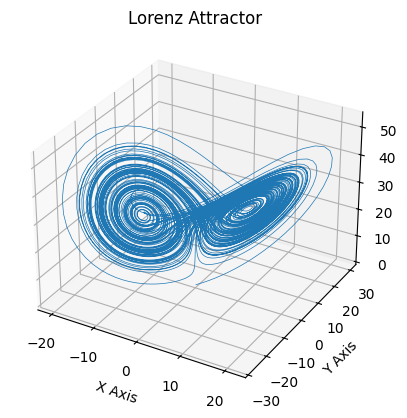

In [11]:
from neurosurfer.agents.code import CodeAgent, CodeAgentConfig

code_agent = CodeAgent(
    llm=LLM,
    config=CodeAgentConfig(
        mode="analysis_only",
        temperature=0.7,
        max_new_tokens=4096,
        log_internal_thoughts=True,
        default_workdir=".",
    ),
    log_traces=True,
)

user_query = """Generate a 3D plot of the Lorenz attractor using synthetic data with the classic (σ=10, ρ=28, β=8/3) parameters."""
agent_restuls = code_agent.run(query=user_query)

In [23]:
# print(agent_restuls.tool_calls[0].output)

## 📚 Retrieval-Augmented Generation (RAG) — Indexing & Querying a Document

This example demonstrates how to use the RAGAgent to ingest documents, build a searchable vector store, and answer queries using retrieved context. It showcases the full RAG pipeline: file reading → chunking → embedding → storage → retrieval → generation.

### 🔧 What this cell sets up
- A **Chunker** to split large documents into semantically meaningful segments.
- A **FileReader** capable of loading DOCX, PDF, text files, and more.
- A **SentenceTransformerEmbedder** to generate vector embeddings (`e5-small-v2`).
- A **RAGAgent** configured with:
  - persistent vector storage,
  - configurable retrieval depth,
  - deduplication,
  - multi-worker ingestion for speed.

### 📁 Ingesting a document
The agent reads the target file, chunks it, computes embeddings, and stores them on disk.  
A summary of ingestion statistics—chunk count, file size, processing time—is printed afterward.

### 🔍 Querying with RAG
We then pose a natural-language question and enable `stream=True` to visualize the answer as it’s generated.  
Under the hood, the RAGAgent:
1. retrieves the most relevant chunks,
2. injects them into the model as context,
3. produces a grounded, reference-aware answer.

### 📌 Why this matters
RAG is essential when working with:
- proprietary documents,
- long technical files,
- research papers,
- project documentation,
- meeting notes and knowledge bases.

This example demonstrates a complete retrieval-augmented workflow integrated directly with the Neurosurfer agent framework.


In [21]:
# scripts/index_repo_for_rag.py
from pathlib import Path
from neurosurfer.models.embedders.sentence_transformer import SentenceTransformerEmbedder
from neurosurfer.agents.rag.chunker import Chunker
from neurosurfer.agents.rag.filereader import FileReader
from neurosurfer.agents.rag import RAGAgent, RAGAgentConfig, RAGIngestorConfig

chunker = Chunker()
file_reader = FileReader()

embedder = SentenceTransformerEmbedder("intfloat/e5-small-v2")
rag_agent = RAGAgent(
    llm=LLM,
    embedder=embedder,
    file_reader=file_reader,
    chunker=chunker,
    config=RAGAgentConfig(
        top_k=5,
        fixed_max_new_tokens=2048,
        clear_collection_on_init=True,
        persist_directory="/home/nomi/rag-storage",
    ),
    ingestor_config=RAGIngestorConfig(
        batch_size=64,
        max_workers=4,
        deduplicate=True,
        normalize_embeddings=True,
        default_metadata=None,
        tmp_dir="/home/nomi/rag-storage",
    ),
)

dir_path = "./temp/AI Demonstration Proposal_Final_Draft.docx"
summary = rag_agent.ingest(sources=dir_path)

print("\nSummary of ingestion:")
for key, value in summary.items():
    print(f"{key}: {value}")
print()

# retrival_results = rag_agent.retrieve(user_query="Explain how graph agent is initialized", top_k=10)
# print("max_new_tokens", retrival_results.max_new_tokens)
# print()
# print(retrival_results.context)


INFO     | 2026-01-04 11:20:53 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2026-01-04 11:20:53 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
WARNING  | 2026-01-04 11:20:53 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Summary of ingestion:
status: ok
sources: 1
chunks: 9
unique_chunks: 9
added: 9
finished_at: 1767511253.6746953
accepted_sources: 1
total_docs_in_collection: 9



In [22]:
# streaming response example
from IPython.display import display, Markdown, clear_output

user_query = """Give me brief summary of the document."""
streaming_response = rag_agent.run(
    user_query, 
    retrieval_mode="smart", 
    stream=True
)

md_display = display(Markdown(""), display_id=True)
response = ""
for chunk in streaming_response.agent_response.response:
    md_display.update(Markdown(response))
    response += chunk

[main_agent] Starting agent...
 ▶ [1][step.agent] agent_id='main_agent' label='rag_agent.run'
[main_agent] Starting RAGAgent retrieve...
 ▶ [1][step.agent] agent_id='main_agent' label='agent.rag.retrieve'
    INFO: [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='smart', scope='full', answer_breadth='summary', optimized_query='summary of the entire document', top_k=50, notes=None, extra=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

    INFO: [RAGAgent.retrieve] Retrieved 9 documents
    INFO: [RAGAgent.retrieve] Untrimmed context: 15423 chars
    INFO: [RAGAgent.retrieve] Trimmed context: 15423 chars
 ◀ [1][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 0.841s; error=False
[main_agent] Completed RAGAgent retrieve!

[main_agent] 🧠 Thinking...
 ▶ [2][step.agent] agent_id='main_agent' label='agent.run'
    [main_agent] Starting llm.call...
     ▶ [3][step.llm.call] agent_id='main_agent' label='agent.free_text_call'
     ◀ [3][step.llm.call] agent_id='main_agent' label='agent.free_text_call' took 0.001s; error=False
    [main_agent] Completed llm.call!
 ◀ [2][step.agent] agent_id='main_agent' label='agent.run' took 0.002s; error=False
[main_agent] 🧠 Done!
 ◀ [1][step.agent] agent_id='main_agent' label='rag_agent.run' took 0.849s; error=False
[main_agent] Completed agent!


The document provides an overview of three AI demonstration projects designed for enterprise and government systems. These projects focus on integrating AI for enhanced productivity, automation, and knowledge management. 

1. **AI Demonstration for eOffice**: This project uses vector-based storage and retrieval of notings for automated summarization and draft generation, improving efficiency in document handling and decision-making.

2. **RAG System Demonstration**: This project presents a Retrieval-Augmented Generation (RAG) framework that transforms unstructured organizational documents into searchable, intelligent knowledge domains. It uses custom models for specific domains like Law, Healthcare, and Finance to provide accurate and explainable answers.

3. **MOM LLM Project**: This project automates meeting documentation by combining speech recognition and language understanding. It transcribes audio inputs and generates structured Minutes of Meeting (MOMs), reducing manual effort and improving accuracy in meeting reporting.

All projects emphasize on-premise deployment for data sovereignty, privacy, cost-efficiency, and scalability. They highlight the use of advanced AI models, vector databases, and modular architectures to deliver context-aware, intelligent solutions.

## 🧩 GraphAgent — Multi-Node Workflow with Web Search, Outlining, Drafting, and Review

This section demonstrates how to use the `GraphAgent` to run a complete multi-stage writing workflow.  
A YAML graph defines the nodes (“research”, “outline”, “draft”, “review”), their tool access, dependencies, and output modes.  
The agent then orchestrates all nodes in sequence using the same LLM, Toolkit, and tracing system.

---

### 🔧 What this cell sets up
- **WebSearchTool** configured with SerpAPI and optional crawling.
- A **Toolkit** containing web search, enabling the research node to gather external information.
- A **GraphAgent** configured with:
  - a YAML workflow (`blog_workflow.yml`),
  - per-node policies (temperature, max tokens, structured/text modes),
  - a manager LLM that composes prompts and coordinates all nodes,
  - full tracing for transparency.

---

### 🧭 What happens during execution
The workflow runs node-by-node:

1. **research**  
   - Uses the web search tool to gather key information.  
   - Produces a structured summary exported as JSON.

2. **outline**  
   - Reads the research output.  
   - Generates a structured blog outline in markdown.  
   - Exported as an `.md` file.

3. **draft**  
   - Consumes both the outline and research data.  
   - Produces a long-form article draft (~3000 words).  
   - Exported as markdown.

4. **review**  
   - Reads the draft + research.  
   - Produces a structured technical/editorial review.  
   - Exported as markdown.

The manager LLM composes prompts for each node, ensuring that every tool, dependency, and policy is correctly applied.

---

### 📝 Why GraphAgent is powerful
- It allows you to define entire multi-step, multi-agent workflows declaratively via YAML.  
- Each node can have different modes: free-text, structured, tool-enabled, or special policies.  
- Tools are selectively available only to nodes that require them.  
- Every step is traced, logged, and exportable for inspection or reuse.  
- Output artifacts (research, outline, draft, review) are automatically saved to the `exports/` folder.

---

### 📌 What you see in the console
- Detailed traces for each node  
- Web search execution logs  
- LLM calls and tool routing decisions  
- Final responses for each stage  
- Automatic export notifications

This example showcases how to build full production-grade, multi-agent pipelines using Neurosurfer’s GraphAgent system.


### YAML Flow

In [23]:
# test web search tool
from neurosurfer.tools.websearch import WebSearchTool, WebSearchConfig
from neurosurfer.tools.toolkit import Toolkit

api_key = os.getenv("SERPAPI_KEY", "API Key not found...")
print("API Key: ", f"{api_key[:8]}...")

web_search_tool = WebSearchTool(
    config=WebSearchConfig(
        engine="serpapi",
        engine_kwargs={"api_key": api_key},
        max_results=3,
        enable_crawl=True,
        max_crawl_results=2,
        content_words_limit=2000,
        content_limit_strategy="distributive",
        summarize=False,
        top_k=10,
    ),
    llm=LLM,
)

toolkit = Toolkit(tools=[web_search_tool])
print(toolkit.registry)

API Key:  f443633b...
WARNING  | 2026-01-04 11:41:18 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
INFO     | 2026-01-04 11:41:18 | posthog.py:__init__ | Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent
INFO     | 2026-01-04 11:41:19 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2026-01-04 11:41:19 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
INFO     | 2026-01-04 11:41:19 | toolkit.py:register_tool | Registered tool: web_search
{'web_search': <neurosurfer.tools.websearch.tool.WebSearchTool object at 0x7f5750b668a0>}


In [ ]:
from neurosurfer.models.chat_models.base import BaseChatModel
from neurosurfer.agents.graph import GraphAgent, ManagerConfig

graph_agent = GraphAgent(
    llm=LLM,
    graph_yaml="blog_workflow.yml",
    toolkit=toolkit,
    manager_config=ManagerConfig(
        temperature=0.3,
        max_new_tokens=4096,
    ),
    manager_llm=LLM,
    log_traces=True
)

# Run workflow
# graph_inputs = {
#     "topic_title": "The Missing Middle Layer: Why LLM Systems Need Tool Routers, Not Bigger Models",
#     "query": "Compose a 1000-1500 word blog on why tool-routing layers matter more than scaling LLM size, covering practical design patterns, examples, and tradeoffs.",
#     "audience": "Intermediate ML engineers",
#     "tone": "Practical and slightly opinionated",
# }

graph_inputs = {
    "topic_title": "Stop Treating LLMs as Black Boxes: The Case for Observability-First AI Systems",
    "query": "Compose a 1000-1500 word blog arguing why observability layers are essential in modern LLM systems, including tracing, metrics, feedback loops, and common failure patterns.",
    "audience": "Intermediate ML engineers",
    "tone": "Practical and slightly opinionated",
}

results = graph_agent.run(inputs=graph_inputs)
# result = await run_async(executor.run(inputs=graph_inputs))


INFO     | 2025-12-11 21:14:38 | toolkit.py:register_tool | Registered tool: web_search

[manager] Tracing Start!
 ▶ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
 ◀ [1][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 2.441s; error=False
[manager] Tracing End!

🧠 Thinking...

[research] Tracing Start!
 ▶ [1][step.agent] agent_id='research' label='agent.run'
     ▶ [2][step.llm.call] agent_id='research' label='agent.route_and_call.router_llm_call'
        INFO: Selected tool: web_search
        INFO: Raw inputs: {'query': 'Stop Treating LMs as Black Boxes: The Case for Observability-First AI Systems', 'hl': 'en'}
     ◀ [2][step.llm.call] agent_id='research' label='agent.route_and_call.router_llm_call' took 0.945s; error=False
     ▶ [3][step.tool.execute] agent_id='research' label='agent.route_and_call.tool_execute'
WARNING  | 2025-12-11 21:14:48 | ingestor.py:ingest | Some sources were skipped as unsupported: [None, None]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='classic', scope=None, answer_breadth=None, top_k=10, notes=None, extra=None)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Retrieved 10 documents
INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Untrimmed context: 10397 chars
INFO     | 2025-12-11 21:14:48 | agent.py:retrieve | [RAGAgent.retrieve] Trimmed context: 10397 chars
        INFO: Tool 'web_search' Tool Return: {'query': 'Compose a 1000-1500 word blog arguing why observability layers are essential in modern LL...
     ◀ [3][step.tool.execute] agent_id='research' label='agent.route_and_call.tool_execute' took 6.204s; error=False
 ◀ [1][step.agent] agent_id='research' label='agent.run' took 7.151s; error=False
[research] Tracing End!


[manager] Tracing Start!
 ▶ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
 ◀ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 3.151s; error=False
[manager] Tracing End!

🧠 Thinking...

[outline] Tracing Start!
 ▶ [1][step.agent] agent_id='outline' label='agent.run'


In [22]:
results.model_dump()

{'graph': {'name': 'blog_workflow',
  'description': 'Example multi-agent workflow for writing and reviewing a technical blog using multiple specialized nodes (each node uses an Agent under the hood).\n',
  'inputs': [{'name': 'topic_title',
    'type': 'string',
    'required': True,
    'description': None},
   {'name': 'query', 'type': 'string', 'required': True, 'description': None},
   {'name': 'audience',
    'type': 'string',
    'required': True,
    'description': None},
   {'name': 'tone', 'type': 'string', 'required': True, 'description': None}],
  'nodes': [{'id': 'research',
    'description': None,
    'kind': 'base',
    'purpose': 'Perform focused research on the requested topic titled {topic_title}.',
    'goal': 'Collect key facts, terminology, and references that are directly useful for writing a technical blog post.',
    'expected_result': "A compact, structured summary with sections for 'key_points', 'sources', and 'risks_or_caveats'.",
    'tools': ['web_search']

# GRAPH TEST WITH RAG


In [32]:
import shutil
from neurosurfer.models.chat_models.base import BaseChatModel
from neurosurfer.agents.graph import GraphAgent, ManagerConfig

export_dir = "exports"
shutil.rmtree(export_dir, ignore_errors=True)

graph_agent = GraphAgent(
    llm=LLM,
    graph_yaml="workflows/rag_code_docs_workflow.yml",
    toolkit=None,
    knowledge_sources=["/home/nomi/workspace/neurosurfer/neurosurfer"],
    manager_config=ManagerConfig(
        temperature=0.3,
        max_new_tokens=8000,
    ),
    export_dir=export_dir,
    manager_llm=LLM,
    log_traces=True,
    log_traces_format="markdown"
)

# Run workflow
# graph_inputs = {
#     "topic_title": "The Missing Middle Layer: Why LLM Systems Need Tool Routers, Not Bigger Models",
#     "query": "Compose a 1000-1500 word blog on why tool-routing layers matter more than scaling LLM size, covering practical design patterns, examples, and tradeoffs.",
#     "audience": "Intermediate ML engineers",
#     "tone": "Practical and slightly opinionated",
# }

# graph_inputs = {
#     "query": "How do I reduce hallucinations in a local LLM setup?",
#     "format": "bullet"
# }

graph_inputs={
    "module_path": "neurosurfer/agents/graph/executor.py",
    "doc_title": "GraphExecutor — Design & API",
    "audience": "Neurosurfer contributors",
    "depth": "deep",
}

results = graph_agent.run(inputs=graph_inputs, reset_tracer=True)
# result = await run_async(executor.run(inputs=graph_inputs))

WARNING  | 2026-01-04 12:03:56 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent
WARNING  | 2026-01-04 12:03:56 | agent.py:__init__ | No embedder provided to RAGAgent, using default SentenceTransformerEmbedder
INFO     | 2026-01-04 12:03:56 | agent.py:__init__ | Initializing Embedding model. This may take a moment...
INFO     | 2026-01-04 12:03:57 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2026-01-04 12:03:57 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
INFO     | 2026-01-04 12:03:57 | agent.py:__init__ | Ingesting knowledge base for GraphAgent...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

[graph_agent] Executing Graph...
 ▶ [1][step.graph.execute] agent_id='graph_agent' label='agent.graph.execute'
    
    [manager] Preparing Next Node...
     ▶ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
     ◀ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 1.780s; error=False
    [manager] Next Node Ready For Execution!
    
    [normalize_request] 🧠 Thinking...
     ▶ [3][step.agent] agent_id='normalize_request' label='agent.run'
        [normalize_request] Starting llm.call...
         ▶ [4][step.llm.call] agent_id='normalize_request' label='agent.free_text_call'
         ◀ [4][step.llm.call] agent_id='normalize_request' label='agent.free_text_call' took 0.856s; error=False
        [normalize_request] Completed llm.call!
     ◀ [3][step.agent] agent_id='normalize_request' label='agent.run' took 0.860s; error=False
    [normalize_request] 🧠 Done!
    INFO: Exported node normalize_request output to exports/normalize_request

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

        INFO: [RAGAgent.retrieve] Retrieved 50 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 49582 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 34564 chars
     ◀ [6][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 2.396s; error=False
    [main_agent] Completed RAGAgent retrieve!
    INFO: Retrieved context from knowledge base. Context length: 34564 chats
    
    [retrieve_module_evidence] 🧠 Thinking...
     ▶ [7][step.agent] agent_id='retrieve_module_evidence' label='agent.run'
        [retrieve_module_evidence] Starting llm.call...
         ▶ [8][step.llm.call] agent_id='retrieve_module_evidence' label='agent.free_text_call'
         ◀ [8][step.llm.call] agent_id='retrieve_module_evidence' label='agent.free_text_call' took 18.093s; error=False
        [retrieve_module_evidence] Completed llm.call!
     ◀ [7][step.agent] agent_id='retrieve_module_evidence' label='agent.run' took 18.095s; error=False
    [retrieve_module_evidence] 🧠 Done!

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

        INFO: [RAGAgent.retrieve] Retrieved 10 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 8977 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 8977 chars
     ◀ [10][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.812s; error=False
    [main_agent] Completed RAGAgent retrieve!
    INFO: Retrieved context from knowledge base. Context length: 8977 chats
    
    [build_symbol_map] 🧠 Thinking...
     ▶ [11][step.agent] agent_id='build_symbol_map' label='agent.run'
        [build_symbol_map] Starting llm.call...
         ▶ [12][step.llm.call] agent_id='build_symbol_map' label='agent.free_text_call'
         ◀ [12][step.llm.call] agent_id='build_symbol_map' label='agent.free_text_call' took 14.143s; error=False
        [build_symbol_map] Completed llm.call!
     ◀ [11][step.agent] agent_id='build_symbol_map' label='agent.run' took 14.147s; error=False
    [build_symbol_map] 🧠 Done!
    INFO: Exported node build_symbol_map output to exports/bu

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

        INFO: [RAGAgent.retrieve] Retrieved 20 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 19612 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 19612 chars
     ◀ [17][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.402s; error=False
    [main_agent] Completed RAGAgent retrieve!
    INFO: Retrieved context from knowledge base. Context length: 19612 chats
    
    [draft_usage_examples] 🧠 Thinking...
     ▶ [18][step.agent] agent_id='draft_usage_examples' label='agent.run'
        [draft_usage_examples] Starting llm.call...
         ▶ [19][step.llm.call] agent_id='draft_usage_examples' label='agent.free_text_call'
         ◀ [19][step.llm.call] agent_id='draft_usage_examples' label='agent.free_text_call' took 11.357s; error=False
        [draft_usage_examples] Completed llm.call!
     ◀ [18][step.agent] agent_id='draft_usage_examples' label='agent.run' took 11.361s; error=False
    [draft_usage_examples] 🧠 Done!
    INFO: Exported node dr

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

        INFO: [RAGAgent.retrieve] Retrieved 20 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 17252 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 17252 chars
     ◀ [27][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.455s; error=False
    [main_agent] Completed RAGAgent retrieve!
    INFO: Retrieved context from knowledge base. Context length: 17252 chats
    
    [groundedness_check] 🧠 Thinking...
     ▶ [28][step.agent] agent_id='groundedness_check' label='agent.run'
        [groundedness_check] Starting llm.call...
         ▶ [29][step.llm.call] agent_id='groundedness_check' label='agent.free_text_call'
         ◀ [29][step.llm.call] agent_id='groundedness_check' label='agent.free_text_call' took 0.008s; error=True
        [groundedness_check] Completed llm.call!
     ◀ [28][step.agent] agent_id='groundedness_check' label='agent.run' took 0.010s; error=True
    [groundedness_check] 🧠 Done!
ERROR    | 2026-01-04 12:05:49 | executor.py:_

In [29]:
# print(results.logs)

In [31]:
# results.traces.model_dump()

import json
print(json.dumps(results.traces.model_dump(), indent=2))

{
  "steps": [
    {
      "step_id": 1,
      "kind": "graph.execute",
      "label": "agent.graph.execute",
      "node_id": null,
      "agent_id": "graph_agent",
      "started_at": 1767513429.469487,
      "duration_ms": 5600,
      "inputs": {
        "inputs": {
          "module_path": "neurosurfer/agents/graph/executor.py",
          "doc_title": "GraphExecutor \u2014 Design & API",
          "audience": "Neurosurfer contributors",
          "depth": "deep"
        },
        "manager_temperature": null,
        "manager_max_new_tokens": null
      },
      "outputs": {},
      "meta": {},
      "ok": true,
      "error": null,
      "logs": [
        {
          "ts": 1767513433.4393473,
          "message": "Exported node normalize_request output to exports/normalize_request_20260104_115711.md",
          "data": {},
          "type": "info"
        },
        {
          "ts": 1767513435.0642612,
          "message": "Rag in ReAct Agents is currently not supported. Use tool

## Doc Generation Workflow

In [ ]:
import shutil
from neurosurfer.models.chat_models.base import BaseChatModel
from neurosurfer.agents.graph import GraphAgent, ManagerConfig

export_dir = "exports"
shutil.rmtree(export_dir, ignore_errors=True)

knowledge_sources = ["../neurosurfer/agents"]
graph_agent = GraphAgent(
    llm=LLM,
    graph_yaml="doc_gen_workflow.yml",
    toolkit=None,
    knowledge_sources=knowledge_sources,
    manager_config=ManagerConfig(
        temperature=0.3,
        max_new_tokens=4096,
    ),
    export_dir=export_dir,
    manager_llm=LLM,
    log_traces=True,
    log_traces_format="text"
)

# Run workflow
graph_inputs = {
    "project_name": "neurosurfer_tracing_docs",
    "module_path": "../neurosurfer/tracing",
    "target_audience": "Intermediate ML engineers",
    "tone": "Practical and concise",
    "doc_depth": "deep",
    "output_format": "mkdocs"
  }

results = graph_agent.run(inputs=graph_inputs, reset_tracer=True)
# result = await run_async(executor.run(inputs=graph_inputs))

WARNING  | 2025-12-23 10:39:29 | agent.py:__init__ | No vectorstore provided to RAGAgent, using default ChromaVectorStore. Initializing default collection `neurosurfer-rag-agent`
[Init] ChromaVectorStore initialized with collection: neurosurfer-rag-agent
WARNING  | 2025-12-23 10:39:29 | agent.py:__init__ | No embedder provided to RAGAgent, using default SentenceTransformerEmbedder
INFO     | 2025-12-23 10:39:29 | agent.py:__init__ | Initializing Embedding model. This may take a moment...
INFO     | 2025-12-23 10:39:31 | SentenceTransformer.py:__init__ | Use pytorch device_name: cuda:0
INFO     | 2025-12-23 10:39:31 | sentence_transformer.py:__init__ | SentenceTransformer embedding model initialized.
INFO     | 2025-12-23 10:39:31 | agent.py:__init__ | Ingesting knowledge base for GraphAgent...


Batches: 100%|██████████| 2/2 [00:00<00:00, 16.52it/s]

[graph_agent] Executing Graph...
 ▶ [1][step.graph.execute] agent_id='graph_agent' label='agent.graph.execute'
    
    [manager] Preparing Next Node...
     ▶ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'


     ◀ [2][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 4.088s; error=False
    [manager] Next Node Ready For Execution!
    INFO: Retrieving context from knowledge base...
    [main_agent] Starting agent...
     ▶ [3][step.agent] agent_id='main_agent' label='agent.rag.retrieve'
        INFO: [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='smart', scope='medium', answer_breadth='single_fact', optimized_query='Identify the module root, key files, public objects, non-goals, and documentation entry points based on the provided module_path.', top_k=10, notes=None, 
extra=None)


Batches: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]

        INFO: [RAGAgent.retrieve] Retrieved 10 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 8449 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 8449 chars
     ◀ [3][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.550s; error=False
    [main_agent] Completed agent!
    INFO: Retrieved context from knowledge base. Context length: 8449 chats
    
    [scope_module] 🧠 Thinking...
     ▶ [4][step.agent] agent_id='scope_module' label='agent.run'
        [scope_module] Starting llm.call...
         ▶ [5][step.llm.call] agent_id='scope_module' label='agent.free_text_call'


         ◀ [5][step.llm.call] agent_id='scope_module' label='agent.free_text_call' took 4.363s; error=False
        [scope_module] Completed llm.call!
     ◀ [4][step.agent] agent_id='scope_module' label='agent.run' took 4.364s; error=False
    [scope_module] 🧠 Done!
    INFO: Exported node scope_module output to exports/scope_module_20251223_103936.md
    
    [manager] Preparing Next Node...
     ▶ [6][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
     ◀ [6][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 2.643s; error=False
    [manager] Next Node Ready For Execution!
    INFO: Retrieving context from knowledge base...
    [main_agent] Starting agent...
     ▶ [7][step.agent] agent_id='main_agent' label='agent.rag.retrieve'
        INFO: [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='smart', scope='medium', answer_breadth='summary', optimized_query='Build a structured module_map JSON for the neurosurger_tracing_docs module,

Batches: 100%|██████████| 1/1 [00:00<00:00, 56.62it/s]

        INFO: [RAGAgent.retrieve] Retrieved 30 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 28445 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 28445 chars
     ◀ [7][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.823s; error=False
    [main_agent] Completed agent!
    INFO: Retrieved context from knowledge base. Context length: 28445 chats
    
    [extract_module_map] 🧠 Thinking...
     ▶ [8][step.agent] agent_id='extract_module_map' label='agent.run'
        [extract_module_map] Starting llm.call...
         ▶ [9][step.llm.call] agent_id='extract_module_map' label='agent.free_text_call'


         ◀ [9][step.llm.call] agent_id='extract_module_map' label='agent.free_text_call' took 10.159s; error=False
        [extract_module_map] Completed llm.call!
     ◀ [8][step.agent] agent_id='extract_module_map' label='agent.run' took 10.160s; error=False
    [extract_module_map] 🧠 Done!
    INFO: Exported node extract_module_map output to exports/extract_module_map_20251223_103945.md
    
    [manager] Preparing Next Node...
     ▶ [10][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
     ◀ [10][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 2.891s; error=False
    [manager] Next Node Ready For Execution!
    
    [plan_docs] 🧠 Thinking...
     ▶ [11][step.agent] agent_id='plan_docs' label='agent.run'
        [plan_docs] Starting llm.call...
         ▶ [12][step.llm.call] agent_id='plan_docs' label='agent.free_text_call'
         ◀ [12][step.llm.call] agent_id='plan_docs' label='agent.free_text_call' took 13.800s; error=False
    

Batches: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s]

        INFO: [RAGAgent.retrieve] Retrieved 49 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 47071 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 33594 chars
     ◀ [14][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 1.921s; error=False
    [main_agent] Completed agent!
    INFO: Retrieved context from knowledge base. Context length: 33594 chats
    
    [write_docs] 🧠 Thinking...
     ▶ [15][step.agent] agent_id='write_docs' label='agent.run'
        [write_docs] Starting llm.call...
         ▶ [16][step.llm.call] agent_id='write_docs' label='agent.free_text_call'


         ◀ [16][step.llm.call] agent_id='write_docs' label='agent.free_text_call' took 47.506s; error=False
        [write_docs] Completed llm.call!
     ◀ [15][step.agent] agent_id='write_docs' label='agent.run' took 47.508s; error=False
    [write_docs] 🧠 Done!
    INFO: Exported node write_docs output to exports/write_docs_20251223_104018.md
    
    [manager] Preparing Next Node...
     ▶ [17][step.llm.call] agent_id='manager' label='manager.compose_user_prompt'
     ◀ [17][step.llm.call] agent_id='manager' label='manager.compose_user_prompt' took 3.638s; error=False
    [manager] Next Node Ready For Execution!
    INFO: Retrieving context from knowledge base...
    [main_agent] Starting agent...
     ▶ [18][step.agent] agent_id='main_agent' label='agent.rag.retrieve'
        INFO: [RAGAgent.retrieve] Retrieval plan: RetrievalPlan(mode='smart', scope='medium', answer_breadth='summary', optimized_query='Review the neurosurfer_tracing_docs module documentation for correctness, comple

Batches: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]

        INFO: [RAGAgent.retrieve] Retrieved 30 documents
        INFO: [RAGAgent.retrieve] Untrimmed context: 26256 chars
        INFO: [RAGAgent.retrieve] Trimmed context: 26256 chars
     ◀ [18][step.agent] agent_id='main_agent' label='agent.rag.retrieve' took 2.575s; error=False
    [main_agent] Completed agent!
    INFO: Retrieved context from knowledge base. Context length: 26256 chats
    
    [review_docs] 🧠 Thinking...
     ▶ [19][step.agent] agent_id='review_docs' label='agent.run'
        [review_docs] Starting llm.call...
         ▶ [20][step.llm.call] agent_id='review_docs' label='agent.free_text_call'


         ◀ [20][step.llm.call] agent_id='review_docs' label='agent.free_text_call' took 15.710s; error=False
        [review_docs] Completed llm.call!
     ◀ [19][step.agent] agent_id='review_docs' label='agent.run' took 15.712s; error=False
    [review_docs] 🧠 Done!
    INFO: Exported node review_docs output to exports/review_docs_20251223_104111.md
    INFO: Exported graph traces to exports/traces_20251223_104127.json
 ◀ [1][step.graph.execute] agent_id='graph_agent' label='agent.graph.execute' took 116.234s; error=False
[graph_agent] Graph Execution Complete!
